In [23]:
# !pip install -q ddsketch cvxpy medmnist

In [1]:
from functools import partial
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import cvxpy
import ddsketch
import medmnist
import pandas as pd
import torch
import numpy as np
from ddsketch import DDSketch

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl
from importlib import reload
import src.conformal  as cp
import src.temperature as ts
import src.helpers as helpers
reload(cp)
reload(ts)
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
import matplotlib.ticker as mtick

In [2]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

In [3]:
# path_to_experiments = Path('experiments/')
path_to_experiments = Path('new_experiments/')
# path_to_experiments = Path('../log-experiments/')
# path_to_experiments = Path('../experiments/')

In [163]:
# dataset = 'mnist'
# dataset = 'svhn'
# dataset = 'fashion'
# dataset = 'cifar10'
dataset = 'cifar100'
# dataset = 'bloodmnist'
# dataset = 'dermamnist'
# dataset = 'pathmnist'
# dataset = 'tissuemnist'
dataset = 'fitzpatrick'

experiment_names = ['tct', 'fedavg', 'central', 'tct_iid', 'fedavg_iid']

fst, snd = map(itemgetter, range(2))

if dataset == 'fitzpatrick':
    model = 'efficientnet-b1'
    partition = 'skin_type_partition'
    # partition = 'three_label_partition'
    _val_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'val_df.csv')
    _test_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'test_df.csv')
    df = pd.concat([_val_df, _test_df]).reset_index()
    experiments = {
        # 'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}_pretrained_{partition}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_pretrained_{partition}'), dataset=dataset),
        # 'fedprox': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedprox_{model}_pretrained_{partition}'), dataset=dataset),
        # 'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_pretrained_{partition}'), dataset=dataset),
        # 'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
        # 'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
    }
    num_classes = 114
    clients_class_map = None
else:
    clients_class_map = helpers.get_client_map(dataset)
    num_classes = sum(map(len, clients_class_map.values()))
    model = 'small_resnet14'
    experiments = {
        'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}'), dataset=dataset),
        'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition'), dataset=dataset),
        'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition'), dataset=dataset),
    }
    
experiments = dict(filter(snd, experiments.items()))

In [164]:
def accuracy(scores, targets):
    correct = scores.argmax(1) == targets
    # total = targets.size(0)
    total = targets.shape[0]
    return (correct.sum() / total).item()

In [165]:
for k, v in experiments.items():
    print(f"\n{k.upper().center(20, '=')}")
    print(f" val accuracy {accuracy(v['val_scores'], v['val_targets']):.0%}")
    print(f"test accuracy {accuracy(v['test_scores'], v['test_targets']):.0%}")



========TCT=========
 val accuracy 51%
test accuracy 53%


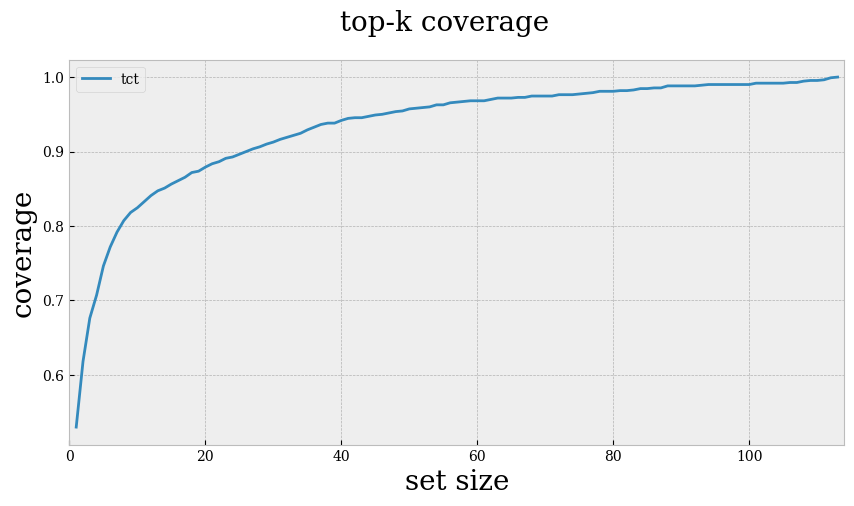

In [166]:
def get_top_k(scores, k=3, return_scores=False):
    # torch.topk()
    sort_index = scores.argsort(1, descending=True)
    sorted_scores = scores.take_along_dim(sort_index, 1)
    top_k_scores = sorted_scores[:, :k]
    mask = torch.zeros_like(scores)
    mask.scatter_(dim=1, index=sort_index[:, :k], src=torch.ones_like(mask))
    mask = mask.bool()
    ret = (mask, top_k_scores) if return_scores else mask
    return ret
   
# for k in range(1, 10):
#     print(f'top_{k} = {coverage(get_top_k(test_scores, k=k), test_targets):.1%}')
fontsize = 20
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
fig.suptitle('top-k coverage', fontsize=fontsize)

# for exp in ('central', 'fedavg', 'tct'):
for exp in experiments.keys():
    val_logits = experiments[exp]['val_scores']
    test_logits = experiments[exp]['test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']
    temp = ts.tune_temp(val_logits, val_targets, binary_search=True, lower=0.2, upper=5.0, eps=0.0001)
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)
    
    top_k_coverage = {k: cp.get_coverage(get_top_k(test_scores, k=k), test_targets) for k in range(1, num_classes)}
    plt.plot(*zip(*top_k_coverage.items()), '-', label=exp)
    
plt.xlim(0, num_classes)
plt.xlabel('set size', fontsize=fontsize)
plt.ylabel('coverage', fontsize=fontsize)
plt.legend()
plt.show()


In [167]:
def get_subset_index(psets, k=10):
    return psets.sum(1) <= k

In [199]:
val_logits = experiments[exp]['val_scores']
test_logits = experiments[exp]['test_scores']
val_targets = experiments[exp]['val_targets']
test_targets = experiments[exp]['test_targets']
temp = ts.tune_temp(val_logits, val_targets, binary_search=True, lower=0.2, upper=5.0, eps=0.0001)
# temp = temp_scale(val_logits, val_targets)
val_scores = torch.softmax(val_logits / temp, 1)
test_scores = torch.softmax(test_logits / temp, 1)


trials = {}
for j in range(20):
    
    # randomly split into calibration and evaluation sets
    trial = helpers.get_new_trial(experiments, fitzpatrick_df=df if dataset == 'fitzpatrick' else None)
    trial_experiments = trial['experiments']
    val_df = trial['val_df']
    test_df = trial['test_df']

    # apply aggregate temperature scaling
    ts.client_temp_scale(
        trial_experiments, clients_class_map, 
        val_df=val_df, test_df=test_df,
        use_three_partition_label=True if partition == 'three_partition_label' else False,
    )
    val_scores = trial_experiments['tct']['temp_val_scores']
    test_scores = trial_experiments['tct']['temp_test_scores']
    val_targets = trial_experiments['tct']['val_targets']
    test_targets = trial_experiments['tct']['test_targets']

    # for i, alpha in enumerate([0.1, 0.2, 0.3]):
    for i, alpha in enumerate([0.1]):
        raps_q = cp.calibrate_raps(val_scores, val_targets, alpha=alpha, k_reg=1, lam_reg = 0.001)
        raps_psets = cp.inference_raps(test_scores, raps_q, allow_empty_sets=False, k_reg=1, lam_reg = 0.001)
        raps_size_results = {
            k: {
                'frac_kept': (index.sum() / index.shape[0]).item(),
                'coverage': cp.get_coverage(raps_psets[index], test_targets[index]),
                'accuracy': accuracy(test_scores[index], test_targets[index]),
            }
            for k in range(0, num_classes, 1)
            if (index := get_subset_index(raps_psets, k)).sum()
        }

        get_frac_kept = itemgetter('frac_kept')
        get_coverage = itemgetter('coverage')
        get_accuracy = itemgetter('accuracy')
        
    trials[j] = raps_size_results
       
    print(f'finished trial={i}')

finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0
finished trial=0


In [ ]:
≤

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


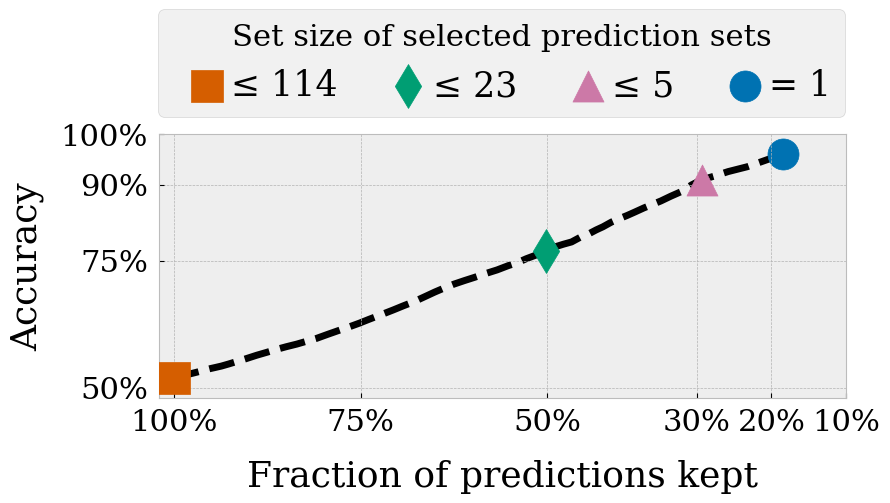

In [455]:
style = '--'
lw = 5
markersize = 16
fontsize=26

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 4))

raps_size_results = helpers.combine_trials(trials)['mean']
ax.plot(list(map(get_frac_kept, raps_size_results.values())), 
        list(map(get_accuracy, raps_size_results.values())), 
        style, color=f'k', lw=lw, markersize=markersize, 
        # marker='o',
        zorder=0,
        # label=fr'$\alpha=${alpha}', 
       )
s = 500
ax.scatter(raps_size_results[113]['frac_kept'], raps_size_results[113]['accuracy'], marker='s', color='C4', s=s, label='≤ 114', zorder=4)
ax.scatter(raps_size_results[23]['frac_kept'], raps_size_results[23]['accuracy'], marker='d', color='C7', s=s, label='≤ 23', zorder=3)
ax.scatter(raps_size_results[5]['frac_kept'], raps_size_results[5]['accuracy'], marker='^', color='C5', s=s, label='≤ 5', zorder=2)
ax.scatter(raps_size_results[1]['frac_kept'], raps_size_results[1]['accuracy'], marker='o', color='C9', s=s, label='= 1', zorder=1)
# ax.axhline(raps_size_results[10]['accuracy'], label=r'$\leq 10$')
ax.set_xlabel('Fraction of predictions kept', fontsize=fontsize, labelpad=16)
ax.set_ylabel('Accuracy', fontsize=fontsize, labelpad=12)
ax.set_xlim(0.1, 1.02)
ax.set_ylim(0.48, 1.00)
ax.xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax.yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
# ax.set_title('Selective classification', fontsize=fontsize)
# ax.legend(fontsize=fontsize, loc='lower right', title_fontsize=fontsize-4, ncol=2)
fig.legend(ncol=4, fontsize=fontsize-1, 
          title='Set size of selected prediction sets', title_fontsize=fontsize-4, 
          bbox_to_anchor=(0.162, 0, 0.802, 1.29), fancybox = True, #shadow = True,
           mode="expand",
           handletextpad=-0.3,
 )
ax.set_xticks([0.1, 0.2, 0.3, 0.5, 0.75, 1])
ax.set_yticks([0.5, 0.75, 0.9, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.invert_xaxis()
plt.tight_layout()
plt.savefig(fig_dir / f'selective-classification-{dataset}.eps', bbox_inches='tight')
plt.show()

In [246]:
raps_size_results[23]

{'frac_kept': 0.5020909115672112,
 'coverage': 0.9362997442483902,
 'accuracy': 0.769875705242157}

In [247]:
raps_size_results[5]

{'frac_kept': 0.29331817775964736,
 'coverage': 0.9509890973567963,
 'accuracy': 0.9097983628511429}

In [250]:
raps_size_results[1]

{'frac_kept': 0.18395454585552215,
 'coverage': 0.9606899619102478,
 'accuracy': 0.9606899619102478}

NameError: name 'coverage' is not defined

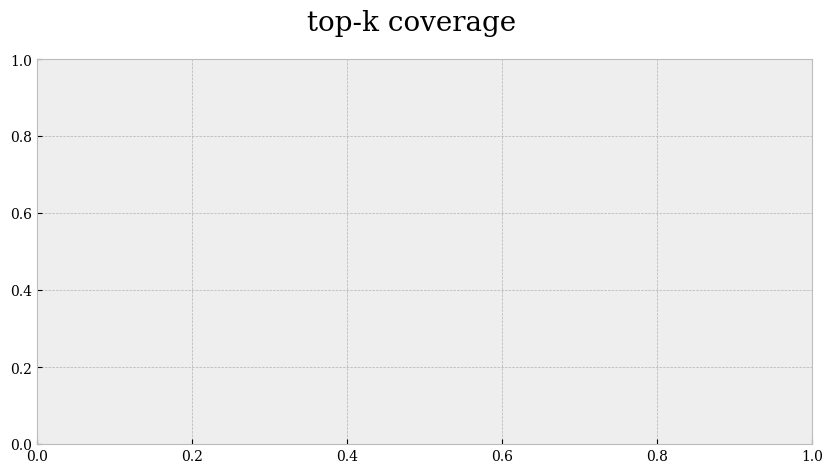

In [10]:
def get_top_k(scores, k=3, return_scores=False):
    # torch.topk()
    sort_index = scores.argsort(1, descending=True)
    sorted_scores = scores.take_along_dim(sort_index, 1)
    top_k_scores = sorted_scores[:, :k]
    mask = torch.zeros_like(scores)
    mask.scatter_(dim=1, index=sort_index[:, :k], src=torch.ones_like(mask))
    mask = mask.bool()
    ret = (mask, top_k_scores) if return_scores else mask
    return ret
   
# for k in range(1, 10):
#     print(f'top_{k} = {coverage(get_top_k(test_scores, k=k), test_targets):.1%}')
fontsize = 20
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
fig.suptitle('top-k coverage', fontsize=fontsize)

# for exp in ('central', 'fedavg', 'tct'):
for exp in experiments.keys():
    val_logits = experiments[exp]['val_scores']
    test_logits = experiments[exp]['test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']
    temp = ts.tune_temp(val_logits, val_targets, binary_search=True, lower=0.2, upper=5.0, eps=0.0001)
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)
    
    top_k_coverage = {k: coverage(get_top_k(test_scores, k=k), test_targets) for k in range(1, num_classes)}
    plt.plot(*zip(*top_k_coverage.items()), '-', label=exp)
    
plt.xlabel('set size', fontsize=fontsize)
plt.ylabel('coverage', fontsize=fontsize)
plt.legend()
plt.show()



In [ ]:
def get_subset_index(psets, k=10):
    return psets.sum(1) <= k